<a href="https://colab.research.google.com/github/kaneelgit/ML-DL-Algorithms/blob/main/contrastive_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size = '6'><center> **Contrastive Learning** </center></font>

Paper - https://arxiv.org/pdf/2002.05709.pdf

In [48]:
#import libraries
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import numpy as np

In [2]:
#hyperparameters
AUTO = tf.data.AUTOTUNE
batch_size = 32
epochs = 100
crop_to = 32
img_size = 32
random_seed = 26 
project_dim = 2048
latent_dim = 512
weight_decay = 0.0005

In [38]:
#get the cifar-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print(f'Total training images: {x_train.shape[0]} & Shape of training data: {x_train.shape}')
print(f'Total testing images: {x_test.shape[0]} & Shape of testing data: {x_test.shape}')

Total training images: 50000 & Shape of training data: (50000, 32, 32, 3)
Total testing images: 10000 & Shape of testing data: (10000, 32, 32, 3)


In [43]:
#defining a data augmentation pipeline
def flip_and_crop(img):
  """
  this function randomly randomly flip the images and crop them
  """

  #create random crops
  img = tf.image.random_flip_left_right(img)
  img = tf.image.random_crop(img, (crop_to, crop_to, 3))

  return img

def color_adjust(img, strength = [0.4, 0.4, 0.4, 0.1]):
  """
  this function randomly changes the brightness, contrast and saturation of the image
  """
  img = tf.image.random_brightness(img, max_delta = 0.8 * strength[0])
  img = tf.image.random_contrast(img, lower = 1 - 0.8 * strength[1], upper = 1 + 0.8 * strength[1])
  img = tf.image.random_saturation(img, lower = 1 - 0.8 * strength[2], upper = 1 + 0.8 * strength[2])
  img = tf.image.random_hue(img, max_delta = 0.2 * strength[3])
  img = tf.clip_by_value(img, 0, 255)

  return img

def color_drop(img):
  """
  drops the color to black and white
  """
  rand_prob = np.random.uniform(0, 1)
  color_or_not = np.random.choice([0, 1], p = [rand_prob, 1 - rand_prob])

  if color_or_not == 0:
    img = img
  else:
    img = tf.image.rgb_to_grayscale(img)
    img = tf.tile(img, [1, 1, 3])
  
  return img

def resize_image(img):
  """
  This function resizes the image to shape (24, 24, 3)
  """
  img = tf.image.resize(img, (24, 24))

  return img


def augment_image(img):
  """
  This function uses the above helper functions to augment images
  """
  img = flip_and_crop(img)
  img = color_adjust(img)
  img = color_drop(img)
  img = resize_image(img)

  return img

In [44]:
#create tensorflow dataset objects

#create two datasets
train_ds_one = tf.data.Dataset.from_tensor_slices(X_train)
train_ds_one = (train_ds_one.shuffle(1024, seed = random_seed).map(augment_image, num_parallel_calls = AUTO).batch(batch_size).prefetch(AUTO))

train_ds_two = tf.data.Dataset.from_tensor_slices(X_train)
train_ds_two = (train_ds_two.shuffle(1024, seed = random_seed).map(augment_image, num_parallel_calls = AUTO).batch(batch_size).prefetch(AUTO))

train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

Sample image set one


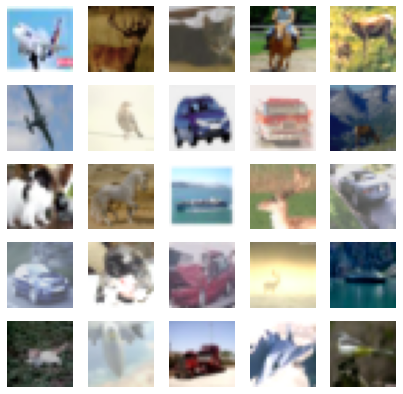

Sample image set two


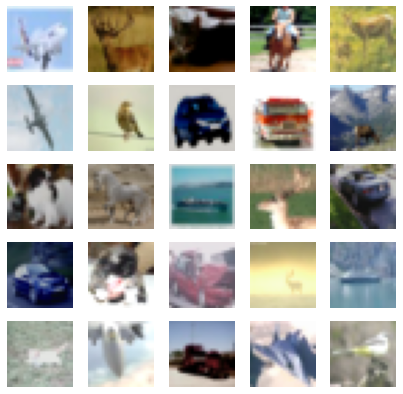

In [45]:
#plot some sample images from both datasets
sample_img_one = next(iter(train_ds_one))
print('Sample image set one')

plt.figure(figsize = (7, 7))

for n in range(25):
  ax = plt.subplot(5, 5, n + 1)
  plt.imshow(sample_img_one[n].numpy().astype('int'))
  plt.axis('off')
plt.show()

#second dataset
sample_img_two = next(iter(train_ds_two))
print('Sample image set two')

plt.figure(figsize = (7, 7))
plt.title('Sample image set 2')

for n in range(25):
  ax = plt.subplot(5, 5, n + 1)
  plt.imshow(sample_img_two[n].numpy().astype('int'))
  plt.axis('off')
plt.show()

In [65]:
#build the residual block 
def residual_block(input_data, filters, kernel_size):
  x = layers.Conv2D(filters, kernel_size, activation = 'relu', padding = 'same')(input_data)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(filters, kernel_size, activation = 'relu', padding = 'same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Add()([x, input_data]) #residual connection
  x = layers.Activation('relu')(x)
  return x

#build the projection head

def encoder_network():
  #inputs
  inputs = keras.Input(shape = (24, 24, 3))
  x = layers.Conv2D(32, 3, activation = 'relu')(inputs)
  x = layers.Conv2D(64, 3, activation = 'relu')(x)

  #repeated residual blocks
  for i in range(10):
    x = residual_block(x, 64, 3)

  x = layers.Conv2D(64, 3, activation = 'relu')(x)
  outputs = layers.AveragePooling2D()(x)
  
  return keras.Model(inputs, outputs)

#create the resnet ()
cfar10_resnet_model = encoder_network()

In [ ]:
#plot the model
plot_model(cfar10_resnet_model, expand_nested = True)

In [ ]:
#model summary 
cfar10_resnet_model.summary()

In [69]:
#create the projection head
def projection_head():

  inputs = keras.Input(shape = (9, 9, 64))
  x = layers.Dense(256, activation = 'relu')(inputs)
  outputs = layers.Dense(10, activation = 'softmax')(x)

  return keras.Model(inputs, outputs)

cfar10_projection_head = projection_head()

In [ ]:
#create the loss function
def compute_loss(i, j, tau = 0.1):

  #do the calculations
  num = tf.tensordot(tf.math.transpose(i), j)
  den = tf.math.l2_normalize(i, axis = 1) * tf.math.l2_normalize(j, axis = 1)

  #similarity value
  sim = num/den 

  #calculate positive pair loss
  l_ij = 


In [ ]:
#create the SIMCLR model